# Sliding Mode Control  for Quadrotor Flying and Grounding

## Dependencies

In [117]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import socket
import random
from time import sleep

# Sliding Mode Control Class

In [118]:
class SlidingModeControl:
    def __init__(self,id_loss,method,T,init_params,N):
        self.m = 0.5
        self.d = 0.2
        self.beta0 = 190
        self.beta1 = 5
        self.beta2 = 0
        self.b = 280
        self.g = 9.8
        self.Ix = 0.003
        self.Iy = 0.003
        self.Iz = 0.007
        self.Kfax = 0.0005
        self.Kfay = 0.0005
        self.Kfaz = 0.0006
        self.Kftx = 0.0005
        self.Kfty = 0.0005
        self.Kftz = 0.0006
        self.Jr = 0.00005
        self.a1 = (self.Iy - self.Iz) / self.Ix
        self.a2 = -self.Kfax / self.Ix
        self.a3 = -self.Jr / self.Ix
        self.a4 = (self.Iz - self.Ix) / self.Iy
        self.a5 = -self.Kfay / self.Iy
        self.a6 = self.Jr / self.Iy
        self.a7 = (self.Ix - self.Iy) / self.Iz
        self.a8 = -self.Kfaz / self.Iz
        self.a9 = -self.Kftx / self.m
        self.a10 = -self.Kfty / self.m
        self.a11 = -self.Kftz / self.m
        self.b1 = self.d / self.Ix
        self.b2 = self.d / self.Iy
        self.b3 = 1 / self.Iz
        self.kdkp = 0.5
        self.U1_arr = []
        self.U2_arr = []
        self.U3_arr = []
        self.U4_arr = []
        self.Ux_arr = []
        self.Uy_arr = []
        self.N = N
        self.id_loss = id_loss
        self.method = method
        self.T = T
        self.init_params = init_params
        
    def Solve_derivatives(self,t):
        self.xd = [0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1, 0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1]
        self.xdd = [np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0,  np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0]
        
    def Loss(self,t):
        self.loss = 0.5*np.sin(2*t)+t
        
    def Solver_one_iter(self, t, x, alpha, q_values, k_values,flag):
        
        ob = x[12] - x[13] + x[14] - x[15]
        z = np.zeros(12)
        self.Solve_derivatives(t)
        
        for w in range(0, 11, 2):
            z[w] = self.xd[w] - x[w]

        for q in range(1, 12, 2):
            z[q] = x[q] - self.xdd[q-1] - alpha[q//2] * z[q-1]

        q1, q2, q3, q4, q5, q6 = q_values[0], q_values[1], q_values[2],q_values[3],q_values[4], q_values[5]
        k1, k2, k3, k4, k5, k6 = k_values[0], k_values[1], k_values[2],k_values[3],k_values[4], k_values[5]

        V1 = z[0]**2 / 2
        V3 = z[2]**2 / 2
        V2 = (V1 + z[1]**2) / 2
        V4 = (V3 + z[3]**2) / 2

        U2 = 1 / self.b1 * (-q1 * np.sign(z[1]) - k1 * z[1] - self.a1 * x[3] * x[5] - self.a2 * x[1]**2 - self.a3 * ob * x[3] + self.xdd[1] + (self.xd[1] - x[1]))
        U3 = 1 / self.b2 * (-q2 * np.sign(z[3]) - k2 * z[3] - self.a4 * x[1] * x[5] - self.a5 * x[3]**2 - self.a6 * ob * x[1] + self.xdd[3] + (self.xd[3] - x[3]))
        U4 = 1 / self.b3 * (-q3 * np.sign(z[5]) - k3 * z[5] - self.a7 * x[1] * x[5] - self.a8 * x[5]**2 + self.xdd[5] + (self.xd[5] - x[5]))

        U1 = self.m / (np.cos(x[0]) * np.cos(x[2])) * (-q6 * np.sign(z[11]) - k6 * z[11] - self.a11 * x[11] + self.xdd[11] + (self.xd[11] - x[11]) + self.g)
        #Forces = np.linalg.solve(np.array([[1,1,1,1],[-d,0,d,0],[0,d,0,-d],[kdkp,-kdkp,kdkp,-kdkp]]),np.array([[U1],[U2],[U3],[U4]]))
        if U1 == 0:
            Ux, Uy = 0, 0
        else:
            Ux = self.m / U1 * (-q4 * np.sign(z[7]) - k4 * z[7] - self.a9 * x[7] + self.xdd[7] + (self.xd[7] - x[7]))
            Uy = self.m / U1 * (-q5 * np.sign(z[9]) - k5 * z[9] - self.a10 * x[9] + self.xdd[9] + (self.xd[9] - x[9]))
        if(flag == 1):
            
            self.U1_arr.append(U1)
            self.U2_arr.append(U2)
            self.U3_arr.append(U3)
            self.U4_arr.append(U4)
            self.Ux_arr.append(Ux)
            self.Uy_arr.append(Uy)
        
        dx1 = x[1]
        dx2 = self.a1 * x[3] * x[5] + self.a2 * (x[1]**2) + self.a3 * ob * x[3] + self.b1 * U2
        dx3 = x[3]
        dx4 = self.a4 * x[1] * x[5] + self.a5 * (x[3]**2) + self.a6 * ob * x[1] + self.b2 * U3
        dx5 = x[5]
        dx6 = self.a7 * x[1] * x[3] + self.a8 * (x[5]**2) + self.b3 * U4
        dx7 = x[7]
        dx8 = self.a9 * x[7] + (Ux * (U1 / self.m))
        dx9 = x[9]
        dx10 = self.a10 * x[9] + (Uy * (U1 / self.m))
        dx11 = x[11]
        dx12 = self.a11 * x[11] + ((np.cos(x[0]) * np.cos(x[2]) * U1) / self.m) - self.g
        dx13 = self.b * V1 - self.beta0 - self.beta1 * x[12] - self.beta2 * (x[12]**2)
        dx14 = self.b * V2 - self.beta0 - self.beta1 * x[13] - self.beta2 * (x[13]**2)
        dx15 = self.b * V1 - self.beta0 - self.beta1 * x[14] - self.beta2 * (x[14]**2)
        dx16 = self.b * V1 - self.beta0 - self.beta1 * x[15] - self.beta2 * (x[15]**2)

        return [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12, dx13, dx14, dx15, dx16]


    def Find_Optimized_Solution(self,params):
        
        alpha = np.full(6, params[0])
        q_values = np.full(6, params[1])
        k_values = np.full(6, params[2])
        
        sol = solve_ivp(self.Solver_one_iter, [0, self.T*self.N], np.zeros(self.T+1), args=(alpha, q_values, k_values,0), method=self.method, t_eval=np.linspace(0, self.T*self.N, 100*self.N))

        t = sol.t
        x = sol.y.T
        self.Loss(t)
        value_desired = self.loss
        value_obtained = x[:, self.id_loss]
        error = np.sum((value_desired - value_obtained) ** 2)
        return error

    def Solver(self):
        result = minimize(self.Find_Optimized_Solution, self.init_params, bounds=[(0, 1), (0, 1), (0, 1)])
        best_params = result.x
        best_error = result.fun
        print('Best Parameters:', best_params)
        print('Best Error:', best_error)
        alpha = np.full(6, best_params[0])
        q_values = np.full(6, best_params[1])
        k_values = np.full(6, best_params[2])

        sol = solve_ivp(self.Solver_one_iter, [0, self.T*self.N], np.zeros(self.T+1), args=(alpha, q_values, k_values,1), method=self.method, t_eval=np.linspace(0, self.T*self.N, 100*self.N))
        self.trajectory = sol.y.T
        return(self.trajectory)
    
    def True_traj(self,t):
        
        return([0.5*np.sin(2*t)+t,np.cos(2*t)+1,t,1,0.1*t,0.1,0.5*np.sin(2*t) + t, np.cos(2*t)+1,t,1,0.1*t,0.1])
    def Plot_two(self):
        
        self.Whole = [[],[],[],[],[],[],[],[],[],[],[],[]]
        tt = np.linspace(0,self.T*self.N,100*self.N)
        for i in range(100*self.N):
            t=tt[i]
            y = self.True_traj(t)
            for j in range(12):
                self.Whole[j].append(y[j])
                x = self.trajectory
                
        Whole = self.Whole
        f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, figsize = (12,14))
        f.suptitle("True and Estimated Trajectories", fontsize=16)
        ax1.plot(x[:,0])
        ax1.plot(Whole[0])        
        ax1.set_title('Roll')
        ax2.plot(x[:,1])
        ax2.plot(Whole[1])
        ax2.set_title('Roll dot')
        ax3.plot(x[:,2])
        ax3.plot(Whole[2])
        ax3.set_title('Pitch')
        ax4.plot(x[:,3])
        ax4.plot(Whole[3])
        ax4.set_title('Pitch dot')
        ax5.plot(x[:,4])
        ax5.plot(Whole[4])
        ax5.set_title('Yaw')
        ax6.plot(x[:,5])
        ax6.plot(Whole[5])
        ax6.set_title('Yaw dot')
        ax7.plot(x[:,6])
        ax7.plot(Whole[6])
        ax7.set_title('X')
        ax8.plot(x[:,7])
        ax8.plot(Whole[7])
        ax8.set_title('X dot')
        ax9.plot(x[:,8])
        ax9.plot(Whole[8])
        ax9.set_title('Y')
        ax10.plot(x[:,9])
        ax10.plot(Whole[9])
        ax10.set_title('Y dot')
        ax11.plot(x[:,10])
        ax11.plot(Whole[10])
        ax11.set_title('Z')
        ax12.plot(x[:,11])
        ax12.plot(Whole[11])
        ax12.set_title('Z dot') 
        
    def Plot_error(self):
        x = self.trajectory
        Whole = self.Whole
        f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, figsize = (12,14))
        f.suptitle("Errors", fontsize=16)
        ax1.plot(x[:,0] - Whole[0])       
        ax1.set_title('Roll')
        ax2.plot(x[:,1]-Whole[1])
        ax2.set_title('Roll dot')
        ax3.plot(x[:,2]-Whole[2])
        ax3.set_title('Pitch')
        ax4.plot(x[:,3]-Whole[3])
        ax4.set_title('Pitch dot')
        ax5.plot(x[:,4]-Whole[4])
        ax5.set_title('Yaw')
        ax6.plot(x[:,5]-Whole[5])
        ax6.set_title('Yaw dot')
        ax7.plot(x[:,6]-Whole[6])
        ax7.set_title('X')
        ax8.plot(x[:,7]-Whole[7])
        ax8.set_title('X dot')
        ax9.plot(x[:,8]-Whole[8])
        ax9.set_title('Y')
        ax10.plot(x[:,9]-Whole[9])
        ax10.set_title('Y dot')
        ax11.plot(x[:,10]-Whole[10])
        ax11.set_title('Z')
        ax12.plot(x[:,11]-Whole[11])
        ax12.set_title('Z dot')  
  
    def Plot_strengths(self):
        f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize = (14,7))
        f.suptitle("Control Laws", fontsize=16)
        ax1.plot(self.U1_arr)       
        ax1.set_title('U1')
        ax2.plot(self.U2_arr)       
        ax2.set_title('U2')
        ax3.plot(self.U3_arr)       
        ax3.set_title('U3')
        ax4.plot(self.U4_arr)       
        ax4.set_title('U4')
        ax5.plot(self.Ux_arr)       
        ax5.set_title('Ux')
        ax6.plot(self.Uy_arr)       
        ax6.set_title('Uy')    

In [119]:
SlMC = SlidingModeControl(6,'RK45',15,[0.1,0.1,0.1],1)

In [120]:
Trajectory = SlMC.Solver()

Best Parameters: [1. 1. 1.]
Best Error: 2.0772365345800727


Text(0.5, 0.92, 'Estimated Trajectory')

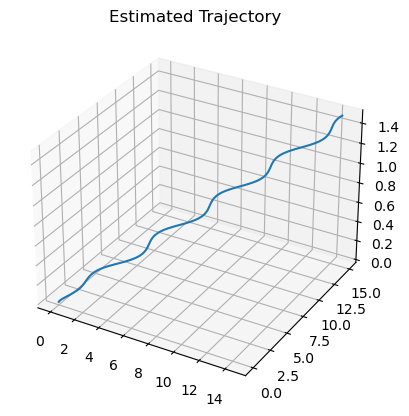

In [121]:
x = Trajectory[:,6]
y = Trajectory[:,8]
z = Trajectory[:,10]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title('Estimated Trajectory')

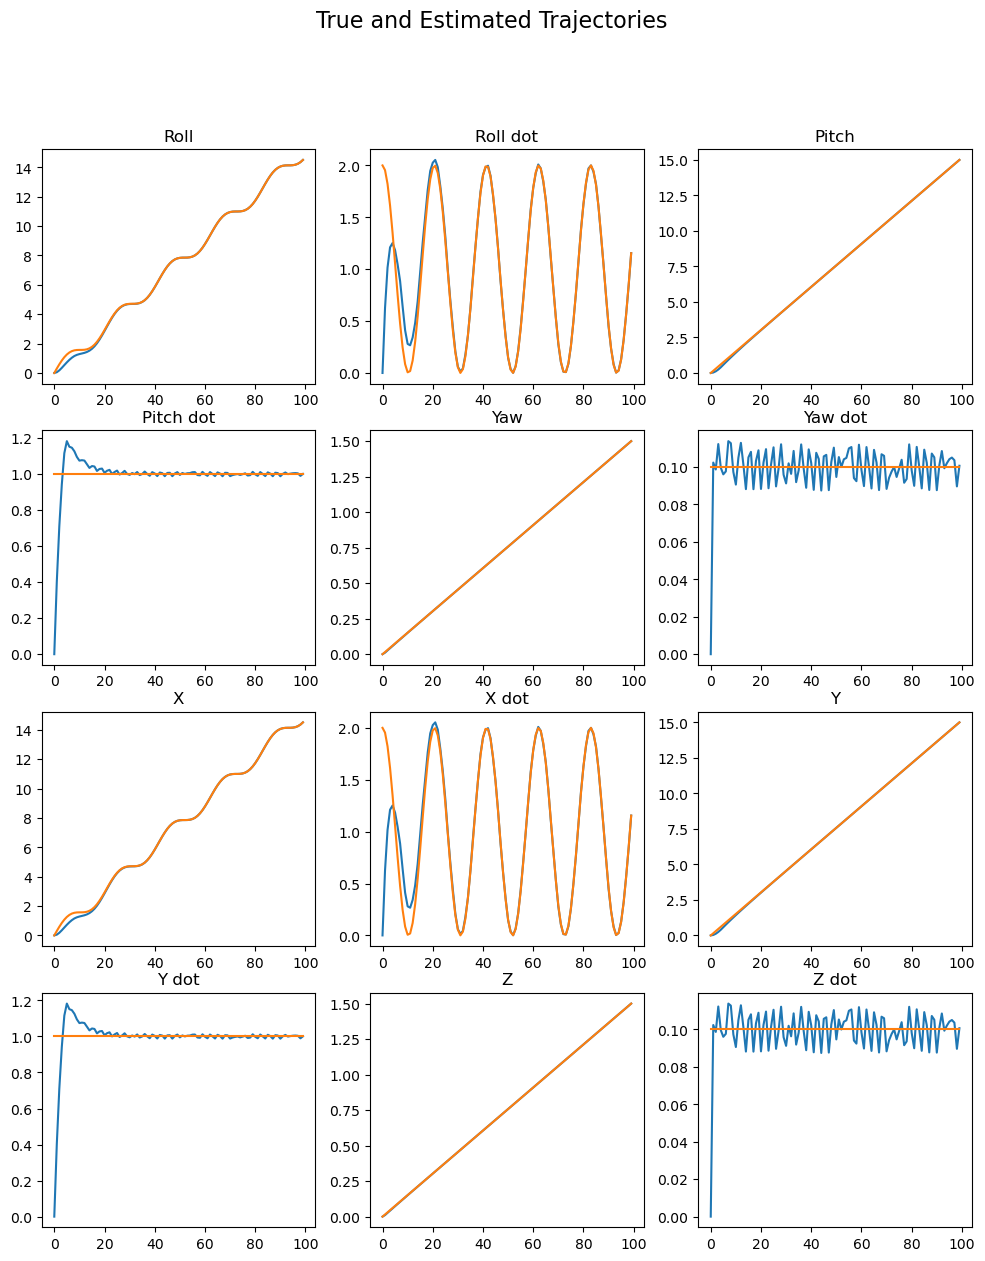

In [99]:
SlMC.Plot_two()

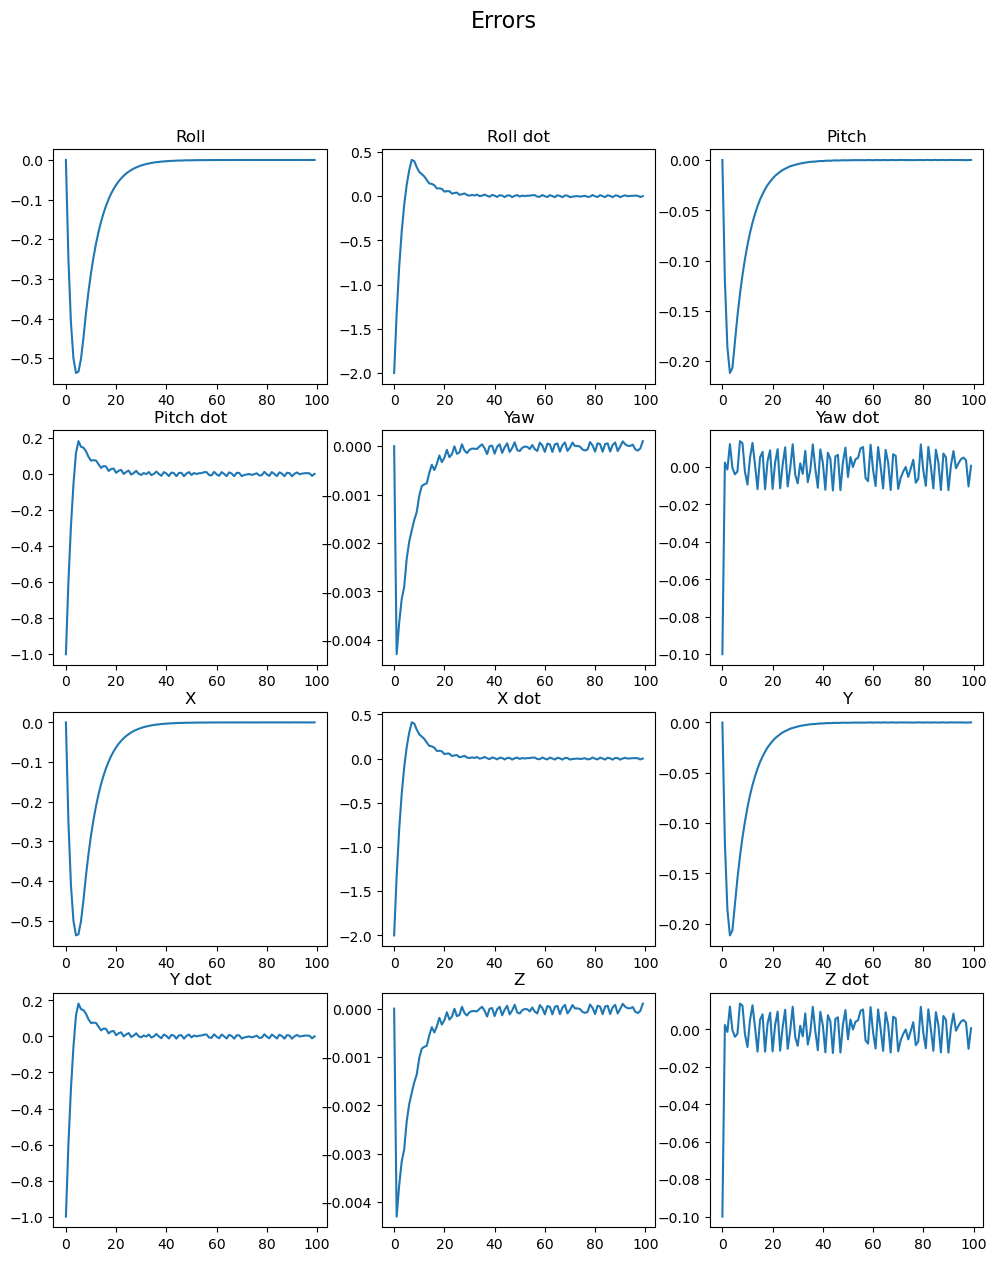

In [100]:
SlMC.Plot_error()

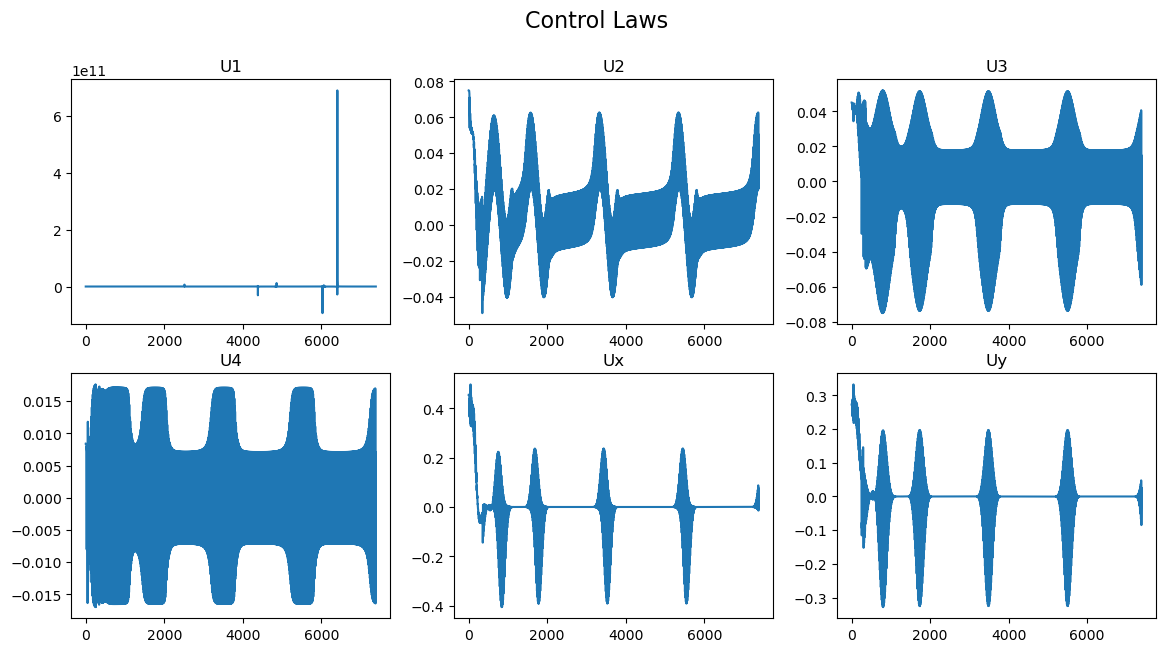

In [101]:
SlMC.Plot_strengths()

In [109]:
class SlidingModeControl_Grounding(SlidingModeControl):
    def True_traj(self,t):
        R3 = -0.78
        return([np.sin(t), np.cos(t), np.cos(t), -np.sin(t), R3*t,R3, np.sin(t), np.cos(t), np.cos(t), -np.sin(t), R3 * t, R3])
    
    def Solve_derivatives(self,t):
        R3 = -0.78
        self.xd =  [np.sin(t), np.cos(t), np.cos(t), -np.sin(t), R3*t,R3, np.sin(t), np.cos(t), np.cos(t), -np.sin(t), R3 * t, R3]
        self.xdd = [np.cos(t), -np.sin(t), -np.sin(t), -np.cos(t), R3,0,np.cos(t), -np.sin(t), -np.sin(t), -np.cos(t), R3, 0]
        
    def Loss(self,t):        
        self.loss = np.sin(t)
    

In [110]:
SlMC_ground = SlidingModeControl_Grounding(6,'RK45',15,[0.1,0.1,0.1],2)

In [111]:
Trajectory_ground = SlMC_ground.Solver()

Best Parameters: [0.08093083 0.08093083 0.27162253]
Best Error: 21.949607056320406


Text(0.5, 0.92, 'Estimated Trajectory')

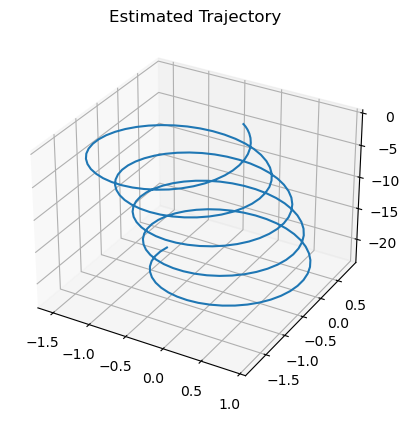

In [116]:
x = Trajectory_ground[:,6]
y = Trajectory_ground[:,8]
z = Trajectory_ground[:,10]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title('Estimated Trajectory')

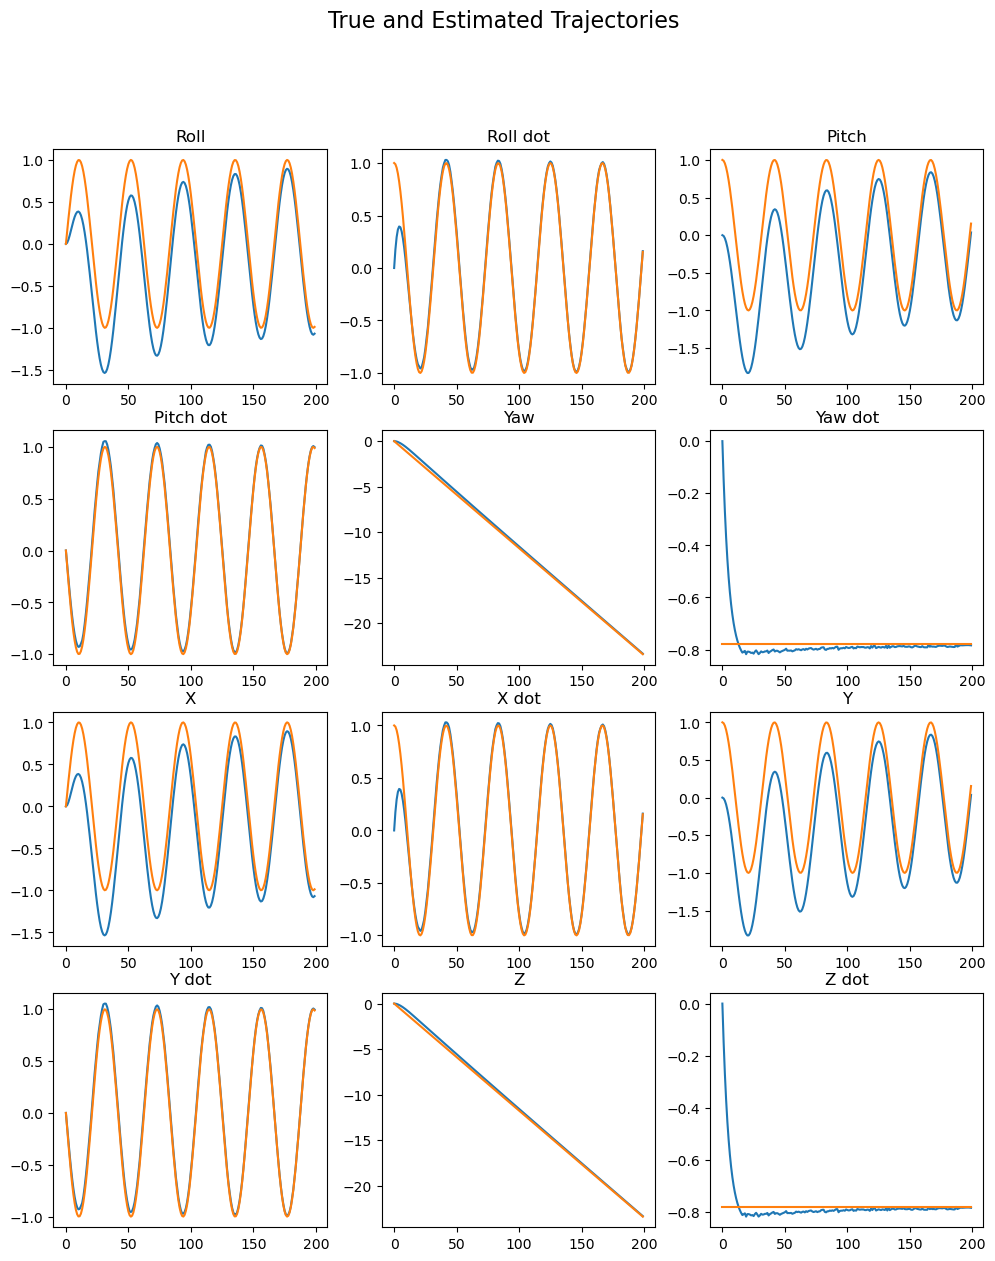

In [112]:
SlMC_ground.Plot_two()

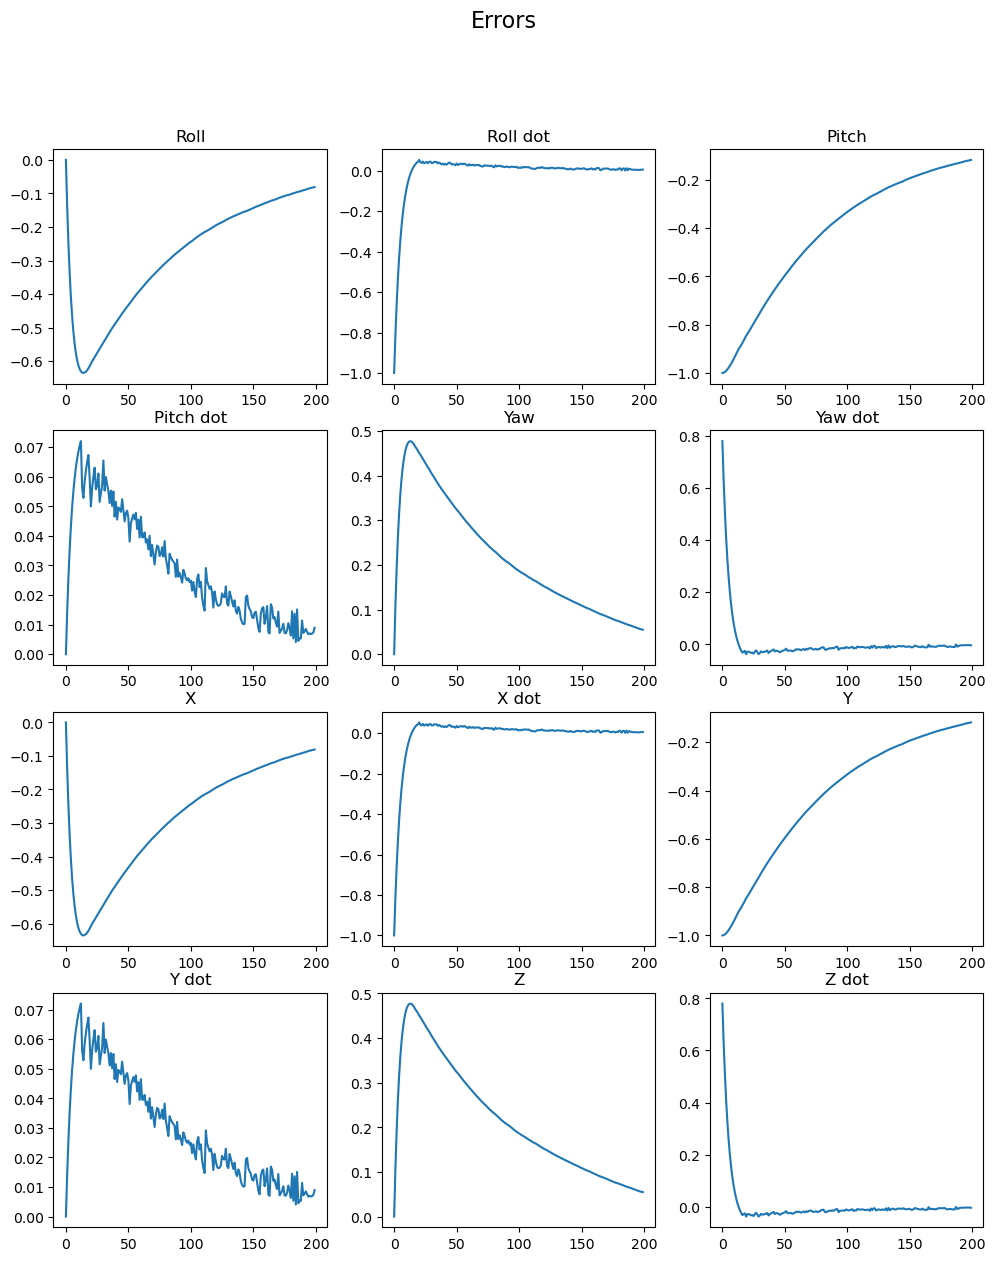

In [113]:
SlMC_ground.Plot_error()

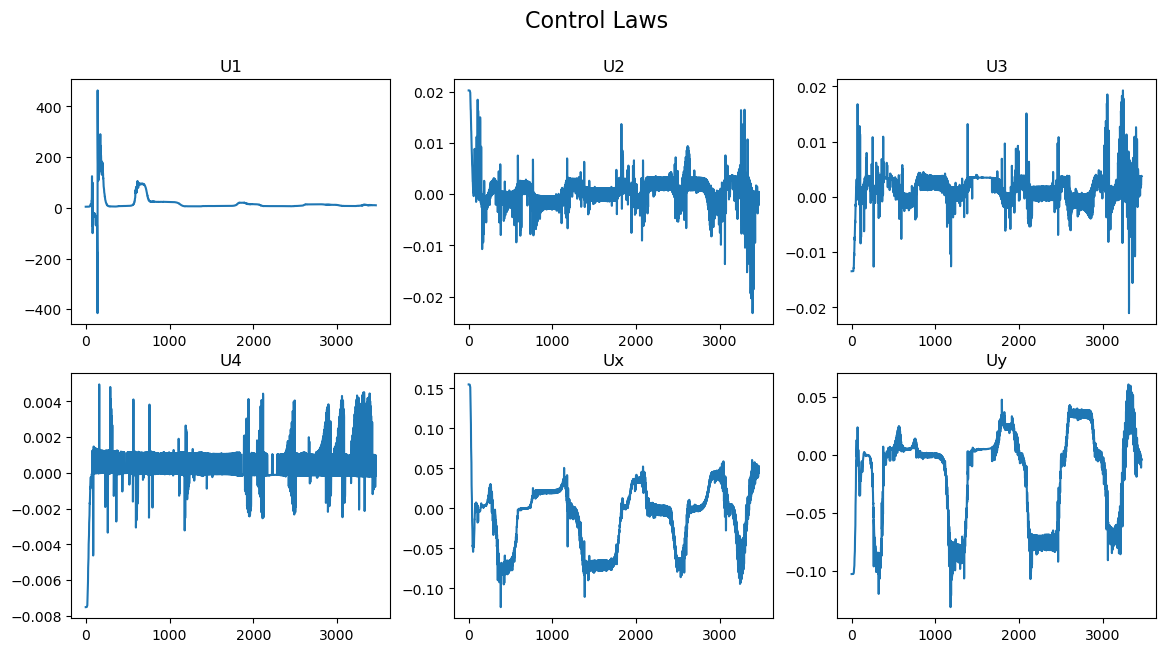

In [114]:
SlMC_ground.Plot_strengths()

# Connection with Unity

In [ ]:
def send_XYZRPY(i,X):
    s = socket.socket()          
              
    # connect to the server on local computer 
    s.connect(('192.168.56.1', 1755))
    s.send((
        str(int(X[i][6]*10)) + ","+ 
        str(int(X[i][8]*10)) + ","+ 
        str(int(X[i][10]*10))+ ","+ 
        str(int(X[i][0]*10)) + ","+ 
        str(int(X[i][2]*10)) + ","+ 
        str(int(int(X[i][4]*10)))).encode())
    s.close()

for i in range(0,100,2):
    send_XYZRPY(i,Trajectory)
    sleep(1)

In [ ]:
for i in range(0,180,2):
    send_XYZRPY(i,Trajectory_ground)
    sleep(1)

## Thanks!